# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.3 MB/s eta 0:00:00


In [ ]:
import h5py
from keras.models import Model
from keras.layers import Input, Activation, Concatenate
from keras.layers import Flatten, Dropout
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D, Lambda
import tensorflow as tf
from keras import backend as K
import keras
import cv2
import mtcnn
from google.colab.patches import cv2_imshow
import numpy as np
import glob
from keras.callbacks import ModelCheckpoint

# Model Architecture

In [ ]:
def fire(x,squeeze,expand,name):


  fire_squeeze = Convolution2D(16, (1, 1), 
                                activation='relu', 
                                kernel_initializer='glorot_uniform',
        padding='same', name=name+"_squeeze",
        data_format="channels_first")(x)
  fire_expand1 = Convolution2D(
        64, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name=name+'_expand1',
        data_format="channels_first")(fire_squeeze)
  fire_expand2 = Convolution2D(
        64, (3, 3), activation='relu', kernel_initializer='glorot_uniform',
        padding='same', name=name+'_expand2',
        data_format="channels_first")(fire_squeeze)
  merge = Concatenate(axis=1)([fire_expand1, fire_expand2])
  
  return merge
  

In [ ]:
def SqueezeNet(nb_classes, inputs,name="SqueezeNet"):
    """ Keras Implementation of SqueezeNet(arXiv 1602.07360)
    @param nb_classes: total number of final categories
    Arguments:
    inputs -- shape of the input images (channel, cols, rows)
    """

    input_img = Input(shape=inputs)
    conv1 = Convolution2D(
        96, (7, 7), activation='relu', kernel_initializer='glorot_uniform',
        strides=(2, 2), padding='same', name='conv1',
        data_format="channels_first")(input_img)

    maxpool1 = MaxPooling2D(
        pool_size=(3, 3), strides=(2, 2), name='maxpool1',
        data_format="channels_first")(conv1)

    fire2 = fire(maxpool1,16,64,name='fire2')
    
    fire3 =  fire(fire2,16,64,name='fire3')

    fire4 =  fire(fire3,32,128,name='fire4')

    maxpool4 = MaxPooling2D(
        pool_size=(3, 3), strides=(2, 2), name='maxpool4',
        data_format="channels_first")(fire4)

    fire5 = fire(maxpool4,32,128,name='fire5')

    fire6 = fire(fire5,48,192,name='fire6')

    fire7 = fire(fire6,48,192,name='fire7')

    fire8 = fire(fire7,64,256,name='fire8')

    maxpool8 = MaxPooling2D(
        pool_size=(3, 3), strides=(2, 2), name='maxpool8',
        data_format="channels_first")(fire8)

    fire9 = fire(maxpool8,64,256,name='fire9')


    dropout = Dropout(0.5,)(fire9)
    conv10 = Convolution2D(
        nb_classes, (1, 1), activation='relu', kernel_initializer='glorot_uniform',
        padding='valid', name='conv10',
        data_format="channels_first")(dropout)

    global_avgpool10 = GlobalAveragePooling2D(data_format='channels_first')(conv10)
    softmax = Activation("softmax", name='softmax')(global_avgpool10)

    return Model(inputs=input_img, outputs=softmax,name=name)

In [ ]:
def euclidean_distance(inputs):
    assert len(inputs) == 2, \
        'Euclidean distance needs 2 inputs, %d given' % len(inputs)
    u, v = inputs
    return K.sqrt(K.sum((K.square(u - v)), axis=1, keepdims=True))
        

def contrastive_loss(y_true,y_pred):
    margin=1.
    return K.mean((1. - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0.)))
   # return K.mean( K.square(y_pred) )

In [ ]:
def siamese_network( model,nb_classes,inputs=(3, 224, 224),name="SiameseNet",dist_func=euclidean_distance):
  left = Input(shape=inputs)
  right = Input(shape=inputs)
  left_features = model(left)
  right_features = model(right)
  distance = Lambda(dist_func, name='distance_layer')([left_features, right_features])
  model = Model(inputs=[left, right], outputs=distance,name=name)
  return model


In [ ]:
embedding_vector_size = 128
image_shape = (3, 225, 225)

In [ ]:
squeezemodel = SqueezeNet(embedding_vector_size,image_shape)

In [ ]:
siamese_squeeze = siamese_network(squeezemodel,embedding_vector_size,image_shape)

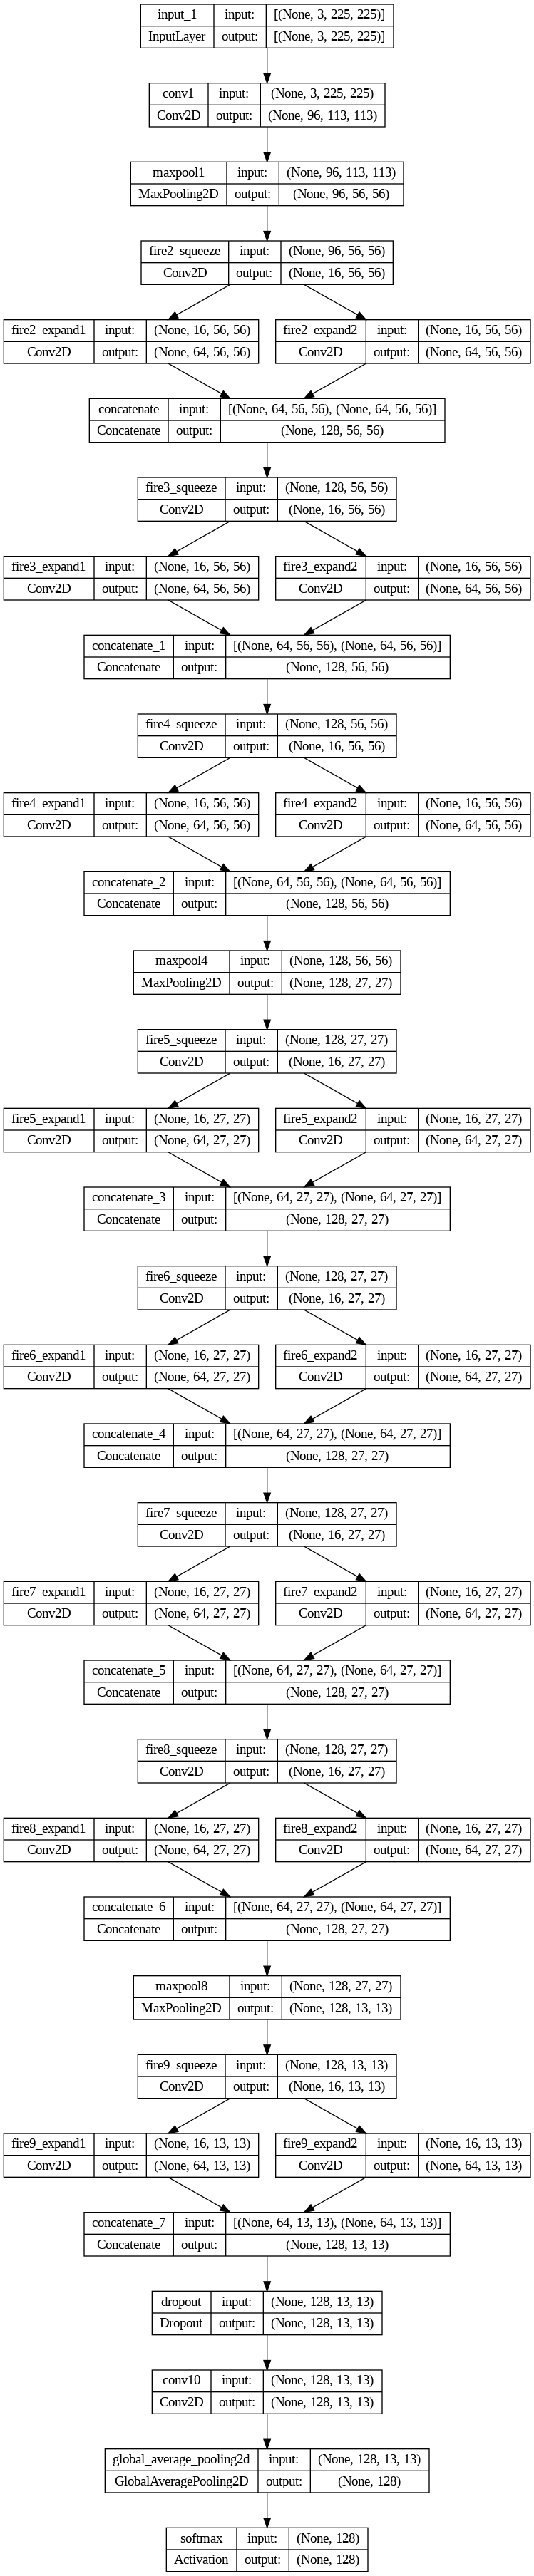

In [ ]:
keras.utils.plot_model(squeezemodel, "squeezenet.png", show_shapes=True,expand_nested=True)

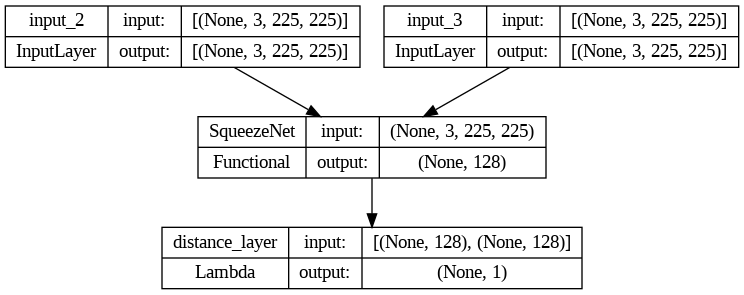

In [ ]:
keras.utils.plot_model(siamese_squeeze, "siamese_net.png", show_shapes=True)

# Dataset Preperation

In [ ]:
# just testing with smaller dataset
# need to replace with larger dataset
! tar -xf '/content/drive/MyDrive/VGGFace2/vggface2_test.tar.gz'


In [ ]:
data = glob.glob('test/*')
len(data)

500

In [ ]:
train = data[:350]
val=data[350:450]
test = data[450:]

In [ ]:
def extract_face(img, input_size,method='haar'):
  if method=='mtcnn':
    detector = mtcnn.MTCNN()
    face = detector.detect_faces(img)
    if len(face)!=1:
      return None
    bbox = face[0]['box']
  else:
    detector = face_detector=cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face = face_detector.detectMultiScale(gray, 1.3, 5)
    if len(face)<1:
      return None
    bbox = face[0]
  [X,Y,W,H] = bbox
  cropped_image = img[Y:Y+H, X:X+W]
  (c,x,y) = input_size
  resized_img = cv2.resize(cropped_image, (x,y),interpolation=cv2.INTER_LINEAR).astype(np.float32)
  resized_img = resized_img/255
  fixed_chanels = np.moveaxis(resized_img, 2, 0) 

  return fixed_chanels

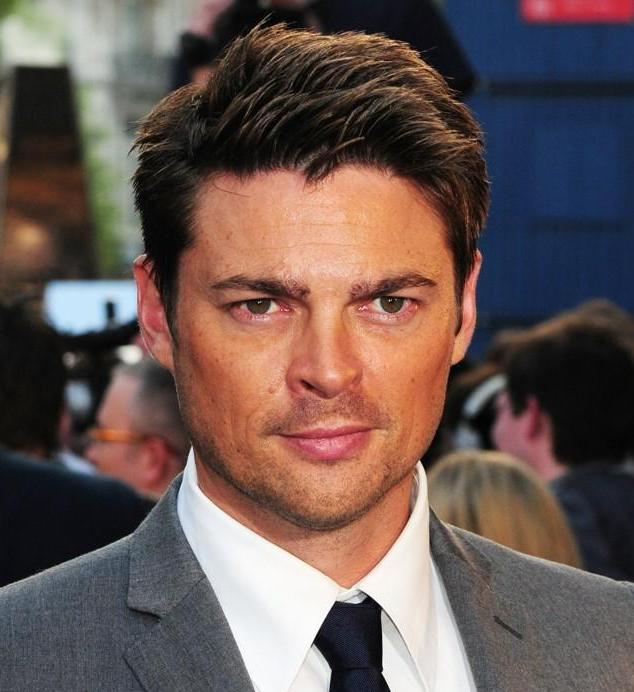

1/1 [==============================] - 0s 129ms/step


In [ ]:
#testing
img = cv2.imread("/content/test/n004586/0001_01.jpg")
cv2_imshow(img)
face1 = extract_face(img,(3,200,200))
face2 = extract_face(img,(3,200,200), method='mtcnn')

In [ ]:
def correct_pair(folder_list):
  # y=0
  pers = np.random.choice(folder_list)
  images = glob.glob(pers+'/*.jpg')
  pair = np.random.choice(images,2,replace=False)
  return pair,0.

def wrong_pair(folder_list):
  #y=1
  pers = np.random.choice(folder_list,2,replace=False)
  img1 = np.random.choice(glob.glob(pers[0]+'/*.jpg'))
  img2 = np.random.choice(glob.glob(pers[1]+'/*.jpg'))
  pair = np.array([img1,img2])
  return pair,1.0


In [ ]:
correct_pair(train)

(array(['test/n000480/0058_01.jpg', 'test/n000480/0023_01.jpg'],
       dtype='<U24'), 0.0)

In [ ]:
wrong_pair(train)

(array(['test/n005776/0106_01.jpg', 'test/n004813/0160_01.jpg'],
       dtype='<U24'), 1.0)

In [ ]:
def img_generator(batch_size,train_list,input_size,method='haar'):
  rng = np.random.default_rng()
  while 1:
    X = []
    Y = []
    while len(X)<batch_size:
      if rng.random()<0.5:
        pair = correct_pair
      else:
        pair = wrong_pair
      [path1,path2],y = pair(train_list)
      img1 = extract_face(cv2.imread(path1),input_size,method=method)
      img2 = extract_face(cv2.imread(path2),input_size,method=method)
      if isinstance(img1,np.ndarray) and isinstance(img2,np.ndarray):
        Y.append(np.array([y]))
        X.append([img1,img2])
      else:
        pass
    X = np.asarray(X)
    Y = np.asarray(Y)
    yield [X[:,0],X[:,1]],Y

# Training and Evaluation

In [ ]:
train_gen = img_generator(16,train,image_shape,)
val_gen = img_generator(4,train,image_shape,)

In [ ]:
siamese_squeeze.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss=contrastive_loss)

In [ ]:
def scheduler(epoch, lr):
   if epoch < 8:
     return lr
   else:
     return lr * tf.math.exp(-0.1)

In [ ]:
from keras.optimizers.schedules import learning_rate_schedule
from datetime import datetime
date = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
path = f"/content/drive/MyDrive/FaceId_checkpoints/Model{date}"
filepath=path + "weights-improvement-128-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
learning_rate_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)
callbacks_list = [checkpoint,learning_rate_schedule]

In [ ]:
history = siamese_squeeze.fit(x=train_gen,
                              steps_per_epoch=15,
                              epochs=30,
                              validation_data=val_gen,
                              validation_steps=10,
                              verbose =1,
                              callbacks = callbacks_list
                              )

Epoch 1/30
15/15 [==============================] - ETA: 0s - loss: 0.5330
Epoch 1: val_loss improved from inf to 0.40555, saving model to /content/drive/MyDrive/FaceId_checkpoints/Model2023_03_20-11_11_42_AMweights-improvement-128-01-0.41.hdf5
15/15 [==============================] - 125s 4s/step - loss: 0.5330 - val_loss: 0.4056 - lr: 0.0010
Epoch 2/30
15/15 [==============================] - ETA: 0s - loss: 0.4113
Epoch 2: val_loss did not improve from 0.40555
15/15 [==============================] - 56s 4s/step - loss: 0.4113 - val_loss: 0.5207 - lr: 0.0010
Epoch 3/30
15/15 [==============================] - ETA: 0s - loss: 0.3484
Epoch 3: val_loss improved from 0.40555 to 0.31553, saving model to /content/drive/MyDrive/FaceId_checkpoints/Model2023_03_20-11_11_42_AMweights-improvement-128-03-0.32.hdf5
15/15 [==============================] - 57s 4s/step - loss: 0.3484 - val_loss: 0.3155 - lr: 0.0010
Epoch 4/30
15/15 [==============================] - ETA: 0s - loss: 0.3688
Epoch 4:

In [ ]:
import pickle
with open(path+"-128.pickle",'wb') as fp:
  pickle.dump(history,fp)

# Trying It out

In [ ]:
img_1 = cv2.imread("/content/drive/MyDrive/Photos/Img1_1.jpg")
img_2 = cv2.imread("/content/drive/MyDrive/Photos/Img2.jpg")
img_12 = cv2.imread("/content/drive/MyDrive/Photos/Img1_2.jpg")

In [ ]:
face_1 = extract_face(img_1,image_shape,method='mtcnn')
face_2 = extract_face(img_2,image_shape,method='mtcnn')
face_12 = extract_face(img_12,image_shape,method='mtcnn')

1/1 [==============================] - 0s 93ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 123ms/step


In [ ]:
face_vec1 = squeezemodel.predict(face_1.reshape((1,3,225,225)))
face_vec12 = squeezemodel.predict(face_12.reshape((1,3,225,225)))
face_vec2 = squeezemodel.predict(face_2.reshape((1,3,225,225)))

1/1 [==============================] - 0s 23ms/step


In [ ]:
euclidean_distance([face_vec1,face_vec12])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.2288004]], dtype=float32)>

In [ ]:
euclidean_distance([face_vec1,face_vec2])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.3096103]], dtype=float32)>

# Saving Weights

In [ ]:
siamese_squeeze.load_weights("/content/drive/MyDrive/FaceId_checkpoints/Model2023_03_20-11_11_42_AMweights-improvement-128-18-0.25.hdf5")

In [ ]:
squeezemodel.weights

[<tf.Variable 'conv1/kernel:0' shape=(7, 7, 3, 96) dtype=float32, numpy=
 array([[[[ 8.34240709e-05, -8.54539685e-03, -1.80544127e-02, ...,
           -3.24451663e-02, -1.21262008e-02, -3.96776684e-02],
          [ 1.97494533e-02, -1.15335146e-02,  4.74513043e-03, ...,
           -1.28545724e-02,  1.96001623e-02,  1.24680139e-02],
          [-2.57734489e-02,  2.72370987e-02, -3.68819805e-03, ...,
            1.94913372e-02, -5.11175394e-03, -6.41505350e-04]],
 
         [[ 3.92596684e-02,  4.15705033e-02,  1.28200580e-03, ...,
            4.32180427e-03,  1.82288103e-02, -8.28216691e-03],
          [ 3.10851634e-02,  7.62311323e-03,  1.79310907e-02, ...,
           -2.09700223e-02, -3.13767828e-02, -3.87075096e-02],
          [-3.60497460e-02, -2.68215276e-02, -3.60270850e-02, ...,
            1.87860690e-02, -1.51966689e-02, -9.02931299e-03]],
 
         [[ 2.18107924e-02, -1.47954784e-02, -2.28218045e-02, ...,
           -3.29172015e-02, -1.07079837e-02, -1.78536121e-02],
          [

In [ ]:
squeezemodel.save("/content/drive/MyDrive/FaceId_checkpoints/squeeze_net_model_final.h5")